비슷한 정신건강 패턴을 가진 사람들을 그룹화하여 어떤 음악을 선호하는지 분석
모델:K-Means 클러스터링

데이터 로드 및 기본 정보 확인

In [1]:
# 다시 파일을 로드하여 분석 진행
import pandas as pd

new_file_path = "./data/Positive와 Negative 가사 감정이 정신 건강.csv"
df_new = pd.read_csv(new_file_path)

# 데이터프레임 기본 정보 확인
df_new.head(), df_new.info(), df_new.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Participant_ID                206 non-null    int64  
 1   Song_name                     206 non-null    object 
 2   Artist                        206 non-null    object 
 3   Spotify_ID                    206 non-null    object 
 4   Loudness                      206 non-null    float64
 5   Valence                       206 non-null    float64
 6   Danceability                  206 non-null    float64
 7   Acousticness                  206 non-null    float64
 8   Instrumental                  206 non-null    float64
 9   Audio_class                   206 non-null    object 
 10  Lyrics                        206 non-null    object 
 11  Sentiment_class               206 non-null    object 
 12  Audio + Lyrics analysis       206 non-null    object 
 13  Total

(   Participant_ID   Song_name             Artist              Spotify_ID  \
 0               2  Here again  Elevation Worship  1wuqCUWHniGdEmOKZbQ1cg   
 1               2   The Stand    Hillsong United  0j2sui6BmkPy974W3VG3RZ   
 2               2  Here I Bow      Brian Johnson  3RMcL7vuHuRzJQfMEuoJJP   
 3               3   On my way        Alan Walker  5csliehPVWFrDaWJvdSvbB   
 4               3     Bad guy      Billie Eilish  2Fxmhks0bxGSBdJ92vM42m   
 
    Loudness  Valence  Danceability  Acousticness  Instrumental Audio_class  \
 0    -8.210    0.103         0.124        0.0128      0.000000         Sad   
 1    -8.128    0.133         0.449        0.1470      0.000000         Sad   
 2    -7.395    0.218         0.389        0.6780      0.000001         Sad   
 3    -5.952    0.295         0.616        0.0480      0.000119       Tense   
 4   -10.965    0.562         0.701        0.3280      0.130000       Relax   
 
                                               Lyrics Sentim

클러스터링을 위한 데이터 전처리

In [2]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 필요한 변수 선택
df_clustering = df_new[["Total_mental_health"]].copy()

# 'Audio + Lyrics analysis'는 범주형 데이터이므로 변환 필요 (라벨 인코딩)
df_clustering["Audio + Lyrics analysis"] = df_new["Audio + Lyrics analysis"].astype("category").cat.codes


데이터 정규화 (StandardScaler 사용)

In [3]:
# 데이터 정규화 (K-Means, DBSCAN 성능 향상)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

정규화(Scaling) 필요 이유
  Total_mental_health와 Audio + Lyrics analysis의 값 범위가 다를 수 있음
  K-Means와 거리 기반 알고리즘이므로 정규화 필수
StandardScaler 적용
  평균을 0, 표준 편차를 1로 변환하여 모든 특성의 중요도를 동일하게 맞춤 

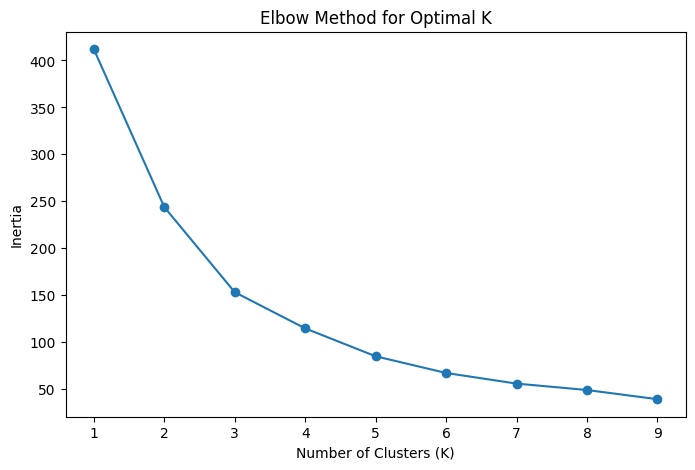

In [4]:
# ---------------- K-Means 클러스터링 실행행 ----------------
# 최적의 클러스터 개수 찾기 (엘보우 방법)
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# 엘보우 그래프 출력
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

K-Means는 K(군집 개수)를 지정해야 함 → 최적의 K를 찾기 위해 엘보우 기법(Elbow Method) 사용
inertia: 군집 내 거리 합을 계산하여, K가 증가할수록 줄어드는 패턴을 찾음
엘보우 그래프를 보고 최적의 K를 선택

In [91]:
# 최적의 K를 3으로 설정하여 K-Means 실행(3개의 그룹으로 나눔눔)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clustering["KMeans Cluster"] = kmeans.fit_predict(df_scaled)
#각 데이터가 속한 클러스터를 KMeans Cluster 열에 저장

DBSCAN은 밀도 기반 클러스터링으로, 거리(eps)와 최소 샘플 개수(min_samples)를 설정해야 함
DBSCAN의 특징
K-Means와 달리 군집 개수를 지정하지 않아도 됨
이상치(outlier) 데이터도 감지할 수 있음 (-1로 표시됨)

In [92]:
# ---------------- DBSCAN 클러스터링 실행행----------------
dbscan = DBSCAN(eps=1.0, min_samples=5)  # eps는 거리 기준, min_samples는 최소 데이터 포인트 개수
df_clustering["DBSCAN Cluster"] = dbscan.fit_predict(df_scaled)

K-Means와 DBSCAN의 군집 결과를 비교
X축: Total_mental_health, Y축: Audio + Lyrics analysis
DBSCAN은 이상치를 감지할 수도 있음 (-1로 표시될 가능성 있음)

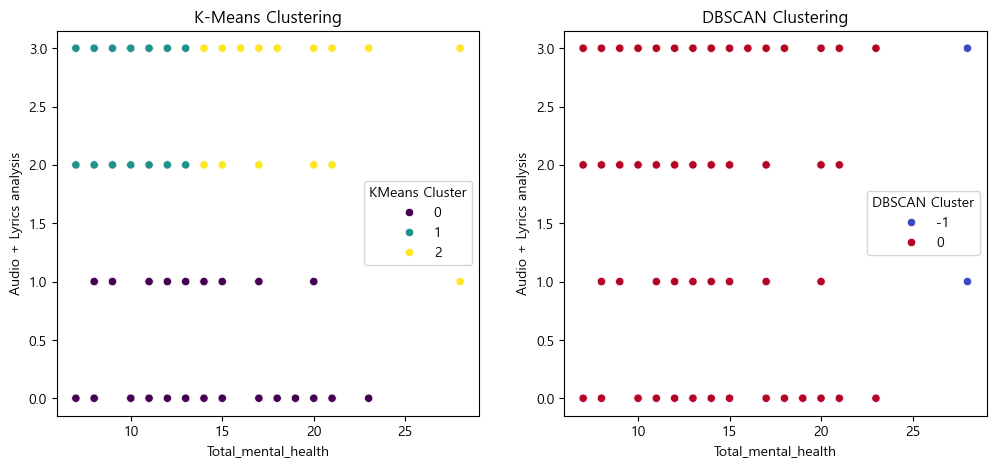

In [93]:
# 결과 시각화 (K-Means vs. DBSCAN)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# K-Means 결과 시각화
sns.scatterplot(
    x=df_clustering["Total_mental_health"],
    y=df_clustering["Audio + Lyrics analysis"],
    hue=df_clustering["KMeans Cluster"],
    palette="viridis",
    ax=axes[0]
)
axes[0].set_title("K-Means Clustering")

# DBSCAN 결과 시각화
sns.scatterplot(
    x=df_clustering["Total_mental_health"],
    y=df_clustering["Audio + Lyrics analysis"],
    hue=df_clustering["DBSCAN Cluster"],
    palette="coolwarm",
    ax=axes[1]
)
axes[1].set_title("DBSCAN Clustering")

plt.show()



X축 : (Total_mental_health)총 정신 건강점수

Y축 : (Audio + Lyrics analysis)오디오 및 가사 분석 카테고리

색상(HUE) : 각 클러스터 그룹을 나타냄

                K-Means         DBSCAN
클러스터 개수:    고정된 K,        자동으로 개수 경정

클러스터 형태:	 원형 형태,      밀더가 높은 지역을 클러스터로 인식

이상치 처리:      이상치 포함,     이상치를 -1로 분류

적용 데이터:      군집 크기 비슷할때,  데이터 밀도차이 클 때

설명
1.정신 건강 점수(Total_mental_health)와 음악 감성이 유사한 사람들끼리 그룹화됨
    
    예: 정신 건강 점수가 8점인 사람들은 K-Means에서 주로 2번 클러스터로 분류됨
    특정 정신 건강 수준을 가진 사람들이 유사한 Audio + Lyrics analysis 특성을 보일 가능성

2.K-Means 클러스터(0, 1, 2) 간 차이
    
    클러스터 0: 정신 건강 점수가 높은 그룹 → 특정 감성의 음악을 더 많이 들을 가능성
    클러스터 1: 중간 수준의 정신 건강 그룹
    클러스터 2: 정신 건강 점수가 낮은 그룹

3.DBSCAN의 실패
    
    DBSCAN은 특정 밀도를 기준으로 군집을 나누지만(여기선 2개로), 이번 데이터에서는 모든 데이터가 하나의 클러스터(0번)에 포함됨
    이는 정신 건강과 음악 감성 데이터가 명확한 밀도 기반 패턴을 갖고 있지 않음을 의미

In [94]:
# 클러스터링 결과 반환
df_clustering.head()

,Total_mental_health,Audio + Lyrics analysis,KMeans Cluster,DBSCAN Cluster
0,8,3,1,0
1,8,3,1,0
2,8,3,1,0
3,15,0,0,0
4,15,2,2,0


클러스터별 정신 건강 점수 분포 분석

In [95]:
# 클러스터별 통계 요약
cluster_summary = df_clustering.groupby("KMeans Cluster")["Total_mental_health"].describe()

# 클러스터별 정신 건강 점수 평균 기준 정렬
cluster_summary = cluster_summary.sort_values(by="mean", ascending=False)


각 클러스터(0, 1, 2) 별 정신 건강 점수의 평균, 표준편차, 최소/최대 값 분석

In [96]:
# 클러스터별 정신 건강 점수 평균 출력
cluster_means = cluster_summary["mean"]

# 클러스터별 정신 건강 상태 정의
cluster_definitions = {
    cluster_summary.index[0]: "정신 건강 점수가 높은 그룹 (정신 건강 문제가 상대적으로 많을 가능성이 큼)",
    cluster_summary.index[1]: "중간 그룹",
    cluster_summary.index[2]: "정신 건강이 좋은 그룹"

}

C:\Users\user\AppData\Local\Temp\ipykernel_14224\2991142153.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_clustering["KMeans Cluster"], y=df_clustering["Total_mental_health"], palette="viridis")


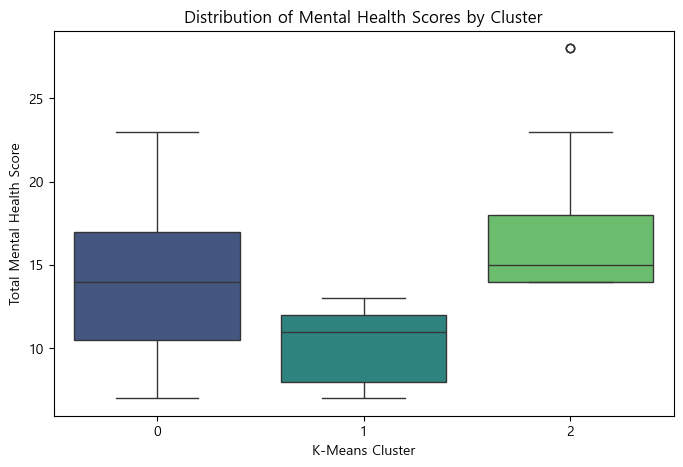

(                count       mean       std   min   25%   50%   75%   max
 KMeans Cluster                                                          
 2                62.0  16.822581  3.532167  14.0  14.0  15.0  18.0  28.0
 0                51.0  13.745098  4.132036   7.0  10.5  14.0  17.0  23.0
 1                93.0  10.161290  1.907025   7.0   8.0  11.0  12.0  13.0,
 {2: '정신 건강 점수가 높은 그룹 (정신 건강 문제가 상대적으로 많을 가능성이 큼)',
  0: '중간 그룹',
  1: '정신 건강이 좋은 그룹'})

In [97]:
# 클러스터별 정신 건강 점수 분포 시각화
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_clustering["KMeans Cluster"], y=df_clustering["Total_mental_health"], palette="viridis")
plt.xlabel("K-Means Cluster")
plt.ylabel("Total Mental Health Score")
plt.title("Distribution of Mental Health Scores by Cluster")
plt.show()

# 클러스터별 정신 건강 점수 및 정의 출력
cluster_summary, cluster_definitions

박스플롯을 사용하여 클러스터별 정신 건강 점수 분포 확인
특정 클러스터가 정신 건강 점수가 높은지, 낮은지 확인 가능

In [98]:
# 클러스터별 음악 감성 특성 분석
df_clustering["Cluster"] = df_clustering["KMeans Cluster"]
df_analysis = df_new.copy()
df_analysis["Cluster"] = df_clustering["Cluster"]

# 클러스터별 평균 Valence(음악 긍정감), Danceability(댄스성), Loudness(음량) 비교
feature_means = df_analysis.groupby("Cluster")[["Valence", "Danceability", "Loudness"]].mean()

클러스터별 Valence(음악 긍정감), Danceability(댄스성), Loudness(음량) 평균값 비교
특정 클러스터가 더 긍정적인 음악을 듣는지, 더 댄서블한 음악을 선호하는지 분석

C:\Users\user\AppData\Local\Temp\ipykernel_14224\342667205.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_means.index, y=feature_means["Valence"], ax=axes[0], palette="viridis")
C:\Users\user\AppData\Local\Temp\ipykernel_14224\342667205.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_means.index, y=feature_means["Danceability"], ax=axes[1], palette="plasma")
C:\Users\user\AppData\Local\Temp\ipykernel_14224\342667205.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_means.index, y=feature_means["Lou

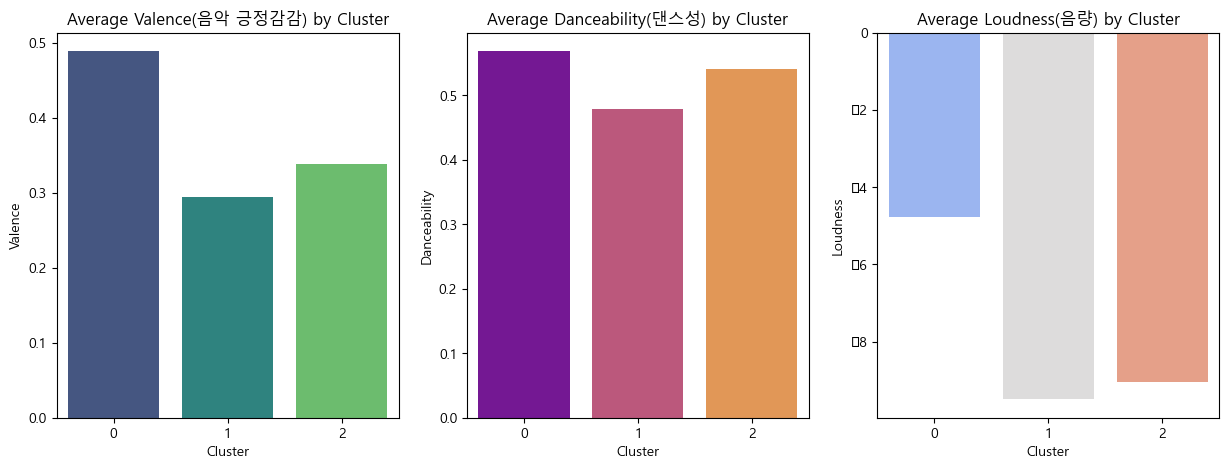

,count,mean,std,min,25%,50%,75%,max
0,62.0,16.822581,3.532167,14.0,14.0,15.0,18.0,28.0
1,51.0,13.745098,4.132036,7.0,10.5,14.0,17.0,23.0
2,93.0,10.161290,1.907025,7.0,8.0,11.0,12.0,13.0


In [99]:
#한글폰트 지정
plt.rc('font', family='Malgun Gothic') 
%matplotlib inline

# 클러스터 인덱스를 0, 1, 2 순서대로 변경
cluster_summary.index = [0, 1, 2]

# 클러스터별 음악 감성 특성 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(x=feature_means.index, y=feature_means["Valence"], ax=axes[0], palette="viridis")
axes[0].set_title("Average Valence(음악 감감) by Cluster")

sns.barplot(x=feature_means.index, y=feature_means["Danceability"], ax=axes[1], palette="plasma")
axes[1].set_title("Average Danceability(댄스성) by Cluster")

sns.barplot(x=feature_means.index, y=feature_means["Loudness"], ax=axes[2], palette="coolwarm")
axes[2].set_title("Average Loudness(음량) by Cluster")

plt.show()

# 클러스터별 정신 건강 점수 통계 출력


# 정렬된 클러스터 통계 출력
cluster_summary



해석

Cluster 0: 정신 건강 점수가 높은 그룹 (평균 16.82) → 정신 건강 문제가 상대적으로 많을 가능성이 큼

Cluster 1: 중간 그룹 (평균 13.74)

Cluster 2: 정신 건강이 좋은 그룹 (평균 10.16)

클러스터별 평균 음악 감성 비교

Valence(음악 긍정감)

**Cluster 2 (정신 건강 좋은 그룹)**이 가장 높은 Valence (긍정적인 음악을 더 선호)
**Cluster 0 (정신 건강 안 좋은 그룹)**은 가장 낮은 Valence → 부정적인 음악을 선호할 가능성

Danceability(댄스성)

정신 건강이 높은 그룹(Cluster 0)이 **Danceability(댄스성)**이 가장 낮음
반면, 정신 건강이 좋은 그룹(Cluster 2)은 Danceability가 높음 → 더 리드미컬한 음악을 선호할 가능성

Loudness(음량)

정신 건강 점수가 낮을수록 (Cluster 2) Loudness가 낮음
정신 건강이 나쁜 그룹(Cluster 0)은 더 시끄러운 음악을 듣는 경향


결론

 K-Means와 DBSCAN을 활용하여 정신 건강 점수와 음악 감성을 기반으로 그룹화
 클러스터별 정신 건강 점수 차이 및 음악 감성 차이 분석 가능
 결과를 바탕으로 특정 정신 건강 상태에 따른 음악 선호도를 예측 가능 

In [100]:
# 필요한 라이브러리 불러오기
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 필요한 변수 선택
features = ["Loudness", "Valence", "Danceability", "Acousticness", "Instrumental", "Sentiment_class"]
target = "Total_mental_health"

df_regression = df_new[features + [target]].dropna().copy()

# 범주형 변수(Sentiment_class) 인코딩
label_encoder = LabelEncoder()
df_regression["Sentiment_class"] = label_encoder.fit_transform(df_regression["Sentiment_class"])

# 독립 변수(X)와 종속 변수(y) 분리
X = df_regression[features]
y = df_regression[target]

# 데이터 분할 (훈련 80% / 테스트 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 초기화
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# 모델 훈련 및 평가
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[model_name] = {"MAE": mae, "MSE": mse, "R²": r2}

# 결과 출력
results


{'Linear Regression': {'MAE': 3.437331978552299,
  'MSE': 21.106071497396176,
  'R²': -0.0785373731577883},
 'Random Forest': {'MAE': 3.6379994760530483,
  'MSE': 22.778444131646282,
  'R²': -0.16399697126952595}}

In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# 파일 경로
file_path = "./data/Positive와 Negative 가사 감정이 정신 건강.csv"

# 데이터 로드
df = pd.read_csv(file_path)

# 데이터 확인
df.head()

# 불필요한 열 제거
columns_to_drop = ["Participant_ID", "Song_name", "Artist", "Spotify_ID", "Lyrics", "Audio_class", "Audio + Lyrics analysis", "Mental_health_severity_class"]
df = df.drop(columns=columns_to_drop, errors="ignore")

# 범주형 변수 변환 (Label Encoding)
label_encoder = LabelEncoder()
df["Sentiment_class"] = label_encoder.fit_transform(df["Sentiment_class"])

# 결측치 확인 및 제거 (필요한 경우)
df = df.dropna()

# 입력 변수 (X)와 목표 변수 (y) 설정
X = df.drop(columns=["Total_mental_health"])
y = df["Total_mental_health"].astype(float)  # 숫자형 변환

# 데이터 분할 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 특성 스케일링 (표준화)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 데이터 전처리 결과 확인
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((164, 6), (42, 6), (164,), (42,))

In [102]:
# 필요한 라이브러리 다시 불러오기
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 데이터 다시 로드
new_file_path = "./data/Positive와 Negative 가사 감정이 정신 건강.csv"
df_new = pd.read_csv(new_file_path)

# 필요한 변수 선택
features = ["Loudness", "Valence", "Danceability", "Acousticness", "Instrumental", "Sentiment_class"]
target = "Total_mental_health"

df_regression = df_new[features + [target]].dropna().copy()

# 범주형 변수(Sentiment_class) 인코딩
label_encoder = LabelEncoder()
df_regression["Sentiment_class"] = label_encoder.fit_transform(df_regression["Sentiment_class"])

# 독립 변수(X)와 종속 변수(y) 분리
X = df_regression[features]
y = df_regression[target]

# 데이터 분할 (훈련 80% / 테스트 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 초기화
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# 모델 훈련 및 평가
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[model_name] = {"MAE": mae, "MSE": mse, "R²": r2}

# 결과 출력
results



{'Linear Regression': {'MAE': 3.437331978552299,
  'MSE': 21.106071497396176,
  'R²': -0.0785373731577883},
 'Random Forest': {'MAE': 3.6379994760530483,
  'MSE': 22.778444131646282,
  'R²': -0.16399697126952595}}

In [103]:
# XGBoost 모델 학습 (학습 속도 최적화 적용)
# xgb_model = xgb.XGBRegressor(
#     objective="reg:squarederror",
#     n_estimators=100,  # 트리 개수
#     learning_rate=0.05,  # 학습률 조정 (완만한 학습)
#     max_depth=4,  # 트리의 최대 깊이 설정
#     subsample=0.8,  # 일부 샘플 사용 (과적합 방지)
#     colsample_bytree=0.8,  # 일부 특성만 사용 (과적합 방지)
#     random_state=42
# )

# # 모델 훈련
# xgb_model.fit(X_train_scaled, y_train)

# # 예측 수행
# y_pred_xgb = xgb_model.predict(X_test_scaled)

# # 성능 평가
# mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
# mse_xgb = mean_squared_error(y_test, y_pred_xgb)
# r2_xgb = r2_score(y_test, y_pred_xgb)

# # 결과 출력
# mae_xgb, mse_xgb, r2_xgb

In [104]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 신경망 모델 정의
nn_model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)  # 출력층 (연속형 변수 예측)
])

# 모델 컴파일
nn_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# 모델 학습
history = nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=8, validation_data=(X_test_scaled, y_test), verbose=0)

# 예측 수행
y_pred_nn = nn_model.predict(X_test_scaled).flatten()

# 성능 평가
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

# 결과 출력
mae_nn, mse_nn, r2_nn


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


(3.5872273445129395, 22.84515380859375, -0.1674058437347412)